## ReproductionExperiment_CaliforniaSmoking
- This note is an attempt to reproduce the original paper. 
- Documentation will be added later.
- original paper : Arkhangelsky, Dmitry, et al. Synthetic difference in differences. No. w25532. National Bureau of Economic Research, 2019. https://arxiv.org/abs/1812.09970

In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys
import os

sys.path.append(os.path.abspath("../"))

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
plt.style.use('ggplot')

from tqdm import tqdm

from synthdid.model import SynthDID
from synthdid.sample_data import fetch_CaliforniaSmoking

In [2]:
df = fetch_CaliforniaSmoking()

PRE_TEREM = [1970, 1988]
POST_TEREM = [1989, 2000]

TREATMENT = ["California"]

df.head()

,Alabama,Arkansas,Colorado,Connecticut,Delaware,Georgia,Idaho,Illinois,Indiana,Iowa,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,West Virginia,Wisconsin,Wyoming,California
1970,89.800003,100.300003,124.800003,120.000000,155.000000,109.900002,102.400002,124.800003,134.600006,108.500000,...,92.699997,99.800003,106.400002,65.500000,122.599998,124.300003,114.500000,106.400002,132.199997,123.000000
1971,95.400002,104.099998,125.500000,117.599998,161.100006,115.699997,108.500000,125.599998,139.300003,108.400002,...,96.699997,106.300003,108.900002,67.699997,124.400002,128.399994,111.500000,105.400002,131.699997,121.000000
1972,101.099998,103.900002,134.300003,110.800003,156.300003,117.000000,126.099998,126.599998,149.199997,109.400002,...,103.000000,111.500000,108.599998,71.300003,138.000000,137.000000,117.500000,108.800003,140.000000,123.500000
1973,102.900002,108.000000,137.899994,109.300003,154.699997,119.800003,121.800003,124.400002,156.000000,110.599998,...,103.500000,109.699997,110.400002,72.699997,146.800003,143.100006,116.599998,109.500000,141.199997,124.400002
1974,108.199997,109.699997,132.800003,112.400002,151.300003,123.699997,125.599998,131.899994,159.600006,116.099998,...,108.400002,114.800003,114.699997,75.599998,151.800003,149.600006,119.900002,111.800003,145.800003,126.699997


In [3]:
melt_df = pd.melt(
    df.reset_index().rename(columns={"index": "year"}),
    id_vars="year",
    value_name="consumption",
    var_name="state",
)
melt_df["is_California"] = melt_df["state"] == "California"
melt_df

,year,state,consumption,is_California
0,1970,Alabama,89.800003,False
1,1971,Alabama,95.400002,False
2,1972,Alabama,101.099998,False
3,1973,Alabama,102.900002,False
4,1974,Alabama,108.199997,False
...,...,...,...,...
1204,1996,California,54.500000,True
1205,1997,California,53.799999,True
1206,1998,California,52.299999,True
1207,1999,California,47.200001,True


- As you can see from the chart below, `the parallel trend assumption` required by DID does not hold.
- The usual solution is to use `Synthetic Control Methods`, but in this case we will use `Synthetic Difference in Differences`.
- This data set is a very famous data set for Synthetic Control Methods. For a more detailed explanation, please refer to the following excellent article

 (see) [15 - Synthetic Control](https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html) in "Causal Inference for The Brave and True."

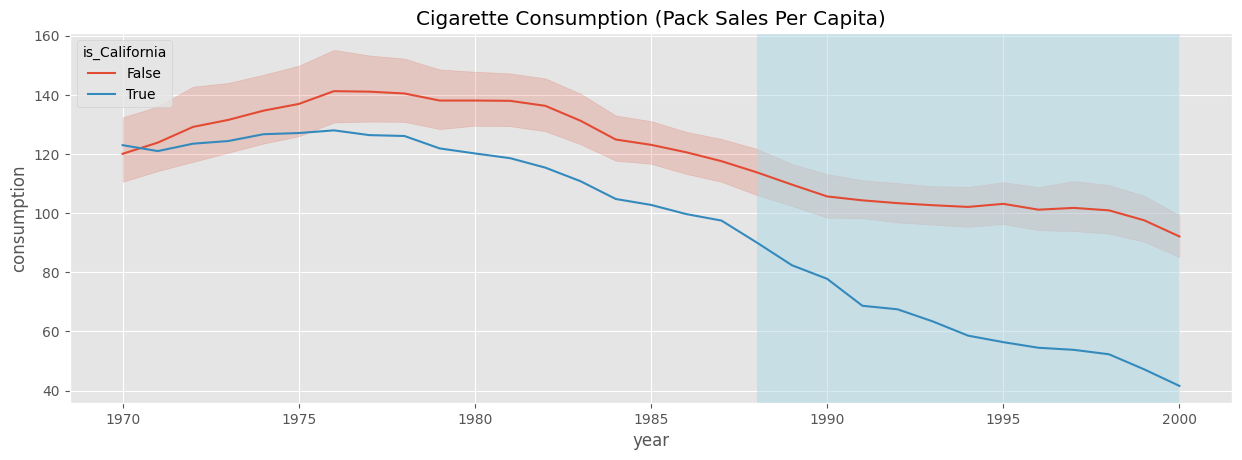

In [4]:
fig, ax = plt.subplots()
fig.set_figwidth(15)

sns.lineplot(x="year", y="consumption", hue="is_California", data=melt_df, ax=ax)

ax.axvspan(1988, 2000, alpha=0.5, color="lightblue")

plt.title("Cigarette Consumption (Pack Sales Per Capita)")
plt.show()

## Synthetic difference in differences
- In the following, we will try to reproduce the original paper using the method of pysynthdid.

In [5]:
sdid = SynthDID(df, PRE_TEREM, POST_TEREM, TREATMENT)

In [6]:
sdid.fit(zeta_type="base")

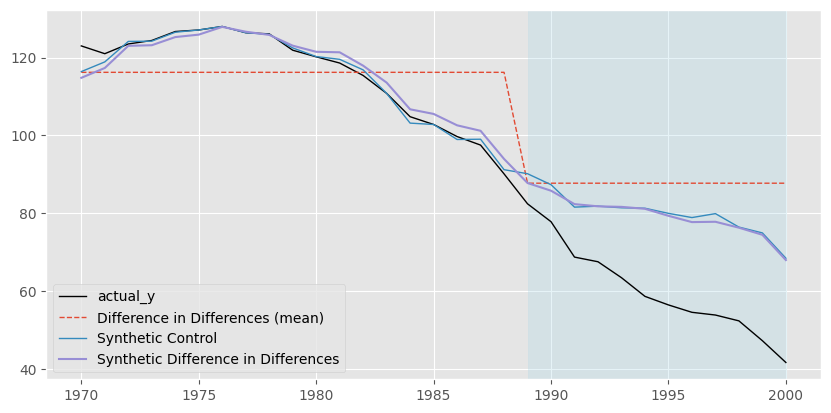

In [7]:
sdid.delta_plot()

### chenk parmas (1) : omega
- Investigate the extent to which the estimated `omega` deviates from the original paper.
- ADH (classic Synth Control) `omega` is almost identical to the original paper.
- The SDID `omega` deviates somewhat from the original paper. Although this can be improved somewhat by running zeta, the essential problem seems to be due to the specification of the optimization algorithm. Although the SDID `omega` deviates slightly from the original paper, the overall trend seems to be fine. As no intercept estimates are available from the original paper, further verification is temporarily terminated.

In [8]:
test_omega = pd.read_csv("../test/test_data/omega_CalifolinaSmoking.csv")

In [9]:
hat_omega = sdid.estimated_params(model="sc")

In [10]:
hat_omega_sdid, hat_lambda_sdid, = sdid.estimated_params()

In [11]:
omega_result = pd.merge(
            test_omega, hat_omega_sdid, left_on="state", right_on="features", how="left"
        )
omega_result = pd.merge(
            omega_result, hat_omega, left_on="features", right_on="features", how="left"
        )

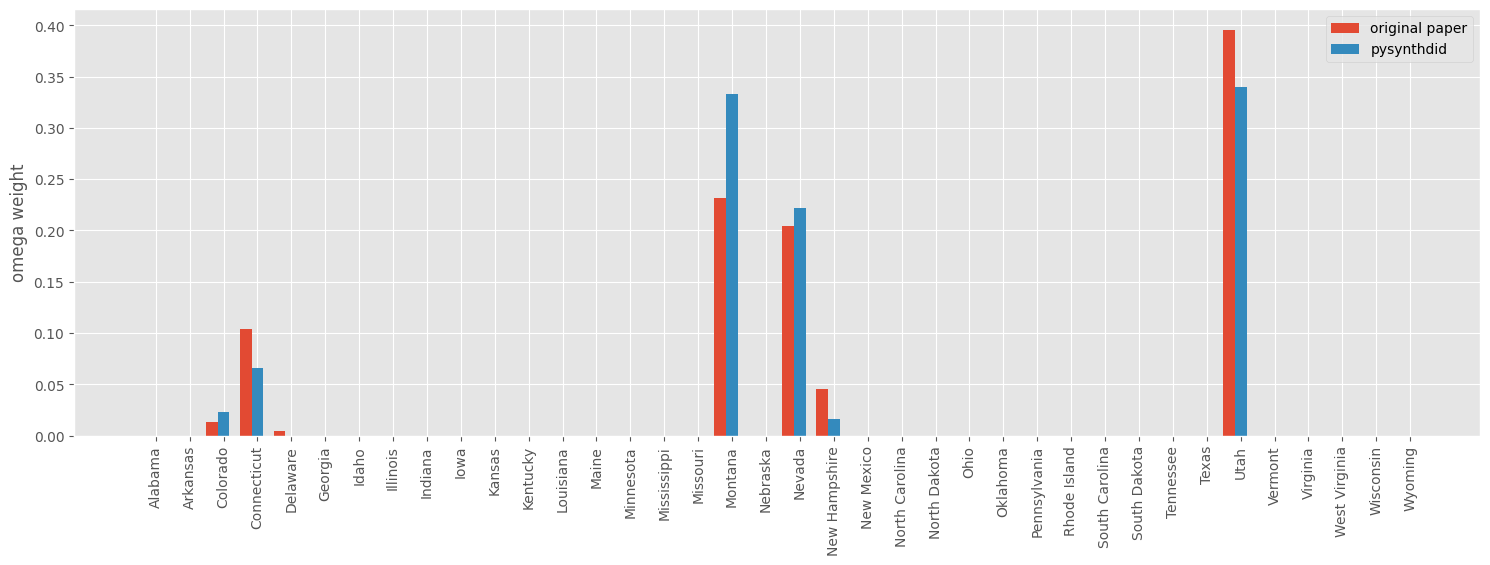

In [12]:
fig = plt.figure()
fig.set_figwidth(15)
ax = fig.add_subplot(1, 1, 1)
width = 0.35
ind = np.arange(len(omega_result))
ax.bar(ind - width, omega_result["omega_ADH"], width, label="original paper")
ax.bar(ind, omega_result["sc_weight"], width, label="pysynthdid")

ax.set_xticks(ind)
ax.set_xticklabels(omega_result["state"].values)
ax.legend()
ax.set_ylabel("omega weight")

fig.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [13]:
print("Synth. Control :")
error_sc_omega = np.sqrt(omega_result.eval("omega_ADH - sc_weight") ** 2).sum()
print("error form original paper: ", error_sc_omega)
adh_corr, _p = spearmanr(omega_result["omega_ADH"], omega_result["sc_weight"])
print("corr. with original paper : ", adh_corr)

Synth. Control :
error form original paper:  0.256
corr. with original paper :  0.9382720349657347


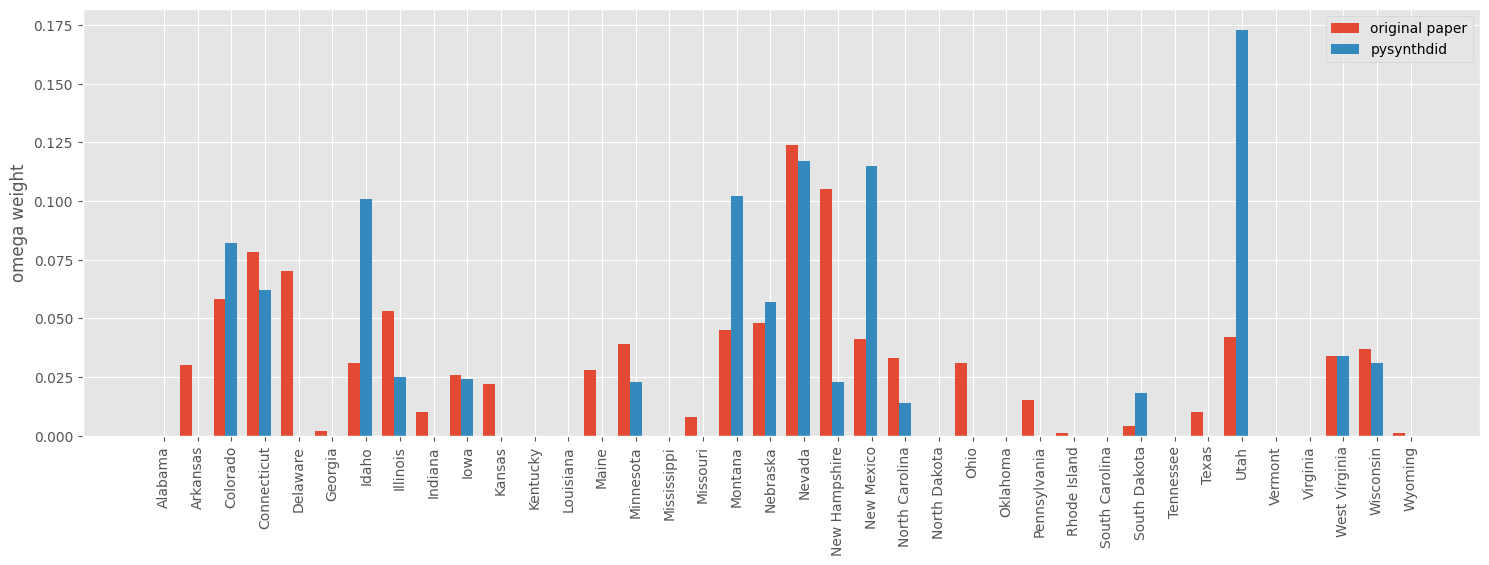

In [14]:
fig = plt.figure()
fig.set_figwidth(15)
ax = fig.add_subplot(1, 1, 1)
width = 0.35
ind = np.arange(len(omega_result))
ax.bar(ind - width, omega_result["omega_sdid"], width, label="original paper")
ax.bar(ind, omega_result["sdid_weight"], width, label="pysynthdid")

ax.set_xticks(ind)
ax.set_xticklabels(omega_result["state"].values)
ax.legend()
ax.set_ylabel("omega weight")

fig.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [15]:
print(f"Synth. Diff in Diff (zeta= {sdid.zeta} ):")
error_sdid_omega = np.sqrt(omega_result.eval("omega_sdid - sdid_weight") ** 2).sum()
print("error form original paper: ",  error_sdid_omega)
sdid_corr, _p = spearmanr(omega_result["omega_sdid"], omega_result["sdid_weight"])
print("corr. with original paper : ",  sdid_corr)

Synth. Diff in Diff (zeta= 12.397359190640767 ):
error form original paper:  0.783
corr. with original paper :  0.757054268984477


(※) Search for zeta that would have been used in the original paper

In [16]:
def error_form_original(_zeta):
    _sdid = SynthDID(df, PRE_TEREM, POST_TEREM, TREATMENT)
    _sdid.fit(zeta_type="base", force_zeta=_zeta)
    
    hat_omega_sdid, hat_lambda_sdid, = _sdid.estimated_params()
    
    omega_result = pd.merge(
            test_omega, hat_omega_sdid, left_on="state", right_on="features", how="left"
        )

    return np.sqrt(omega_result.eval("omega_sdid - sdid_weight") ** 2).sum()

In [17]:
candidate_zata = []
for _z in np.linspace(12 * 0.1, 12 * 1.5,  20):
    candidate_zata.append(_z)
candidate_zata.append(sdid.zeta)

result_loss_dict = {}
for _zeta in tqdm(candidate_zata):
    result_loss_dict[_zeta] = error_form_original(_zeta)

result_loss_zeta = pd.DataFrame(
    result_loss_dict, index=["error_from_original"]
).T.sort_index()

100%|██████████| 21/21 [01:12<00:00,  3.44s/it]


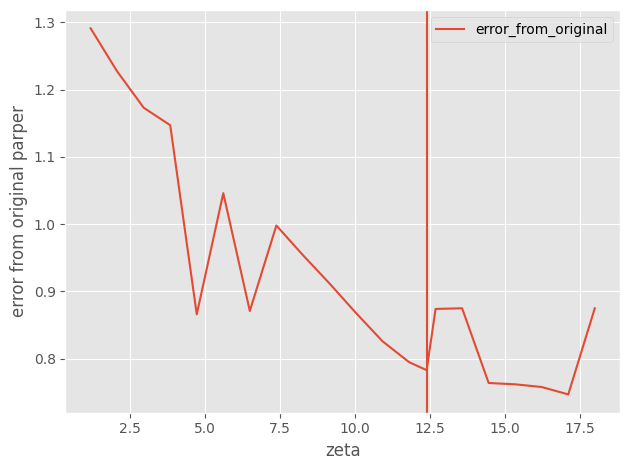

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
result_loss_zeta.plot(ax=ax)

ax.set_xlabel("zeta")
ax.set_ylabel("error from original parper")
ax.axvline(x=sdid.zeta)
fig.tight_layout()
plt.show()

### chenk parmas (2) : lambda
- ` lambda` is almost identical to the original paper

In [19]:
test_lambda = pd.read_csv("../test/test_data/lambda_CalifolinaSmoking.csv")

In [20]:
lambda_result = pd.merge(
            test_lambda, hat_lambda_sdid, left_on="year", right_on="time", how="left"
        )
del lambda_result["time"]

In [21]:
cm = sns.light_palette("green", as_cmap=True)
lambda_result.rename(
    columns={"lambda_sdid": "original paper", "sdid_weight": "pysynthdid"}
).style.background_gradient(cmap=cm,subset=['original paper','pysynthdid'])

,year,original paper,pysynthdid
0,1970,0.000000,0.000000
1,1971,0.000000,0.000000
2,1972,0.000000,0.000000
3,1973,0.000000,0.000000
4,1974,0.000000,0.000000
5,1975,0.000000,0.000000
6,1976,0.000000,0.000000
7,1977,0.000000,0.000000
8,1978,0.000000,0.000000
9,1979,0.000000,0.000000


## AA test
- The following figure is a reproduction of the following slide presentation by Susan Athey (Stanford University)
- slide: Susan Athey (Stanford University) "**Synthetic Differences in Differences.**" https://davidahirshberg.bitbucket.io/static/synth-did-slides.pdf
- This was estimated using the 8 years prior to the California intervention as a pseudo-intervention period (so `the estimated potential outcome = acutal outcome` should hold).

    - The potential outcome of DID is rounded to the mean value in this plot.
    - As shown in the following two charts, the results are generally consistent with those in the slide.

In [22]:
PRE_TEREM2 = [1970, 1979]
POST_TEREM2 = [1980, 1988]
sdid_c = SynthDID(df, PRE_TEREM2, POST_TEREM2,  ["California"])
sdid_nh = SynthDID(df, PRE_TEREM2, POST_TEREM2, ["New Hampshire"])

In [23]:
sdid_c.fit()
sdid_nh.fit()

<img src="fig/california.png">

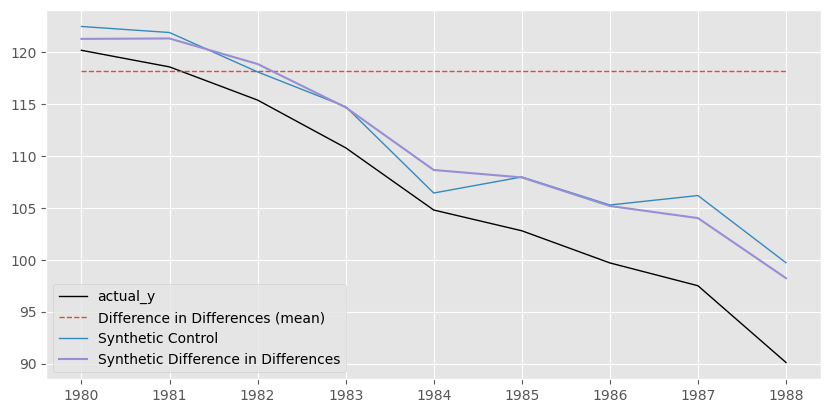

In [24]:
sdid_c.delta_plot(post_only=True)


<img src="fig/NewHampshire.png">

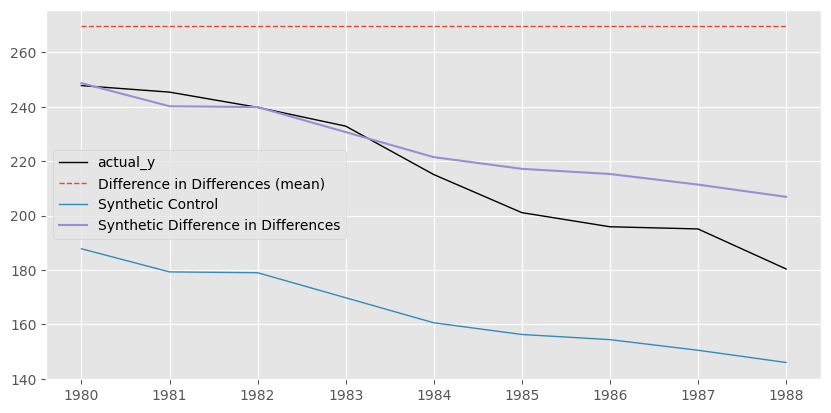

In [25]:
sdid_nh.delta_plot(post_only=True)

- The above work was applied to all the states.
- As shown in the following chart, the proposed method, `Synthetic Difference in Differences (pysynthdid)`, shows better results than the classical `Syntetic Control Methods`.

In [26]:
state_list = df.columns

result_mse_list = []

for _state in tqdm(state_list):
    _sdid = SynthDID(df, PRE_TEREM2, POST_TEREM2, [_state])
    _sdid.fit()

    _outcome = pd.DataFrame({"actual_y": _sdid.target_y()})

    _outcome["did"] = _sdid.did_potentical_outcome()
    _outcome["sc"] = _sdid.sc_potentical_outcome()
    _outcome["sdid"] = _sdid.sdid_potentical_outcome()
    _outcome = _outcome.loc[POST_TEREM2[0] : POST_TEREM2[1]]

    _mse = np.sqrt((_outcome.mean() - _outcome.mean()["actual_y"]) ** 2)
    _mse = pd.DataFrame(_mse).T[["did", "sc", "sdid"]]
    _mse.index = [_state]

    result_mse_list.append(_mse)

100%|██████████| 39/39 [02:13<00:00,  3.42s/it]


In [27]:
result_mse = pd.concat(result_mse_list)

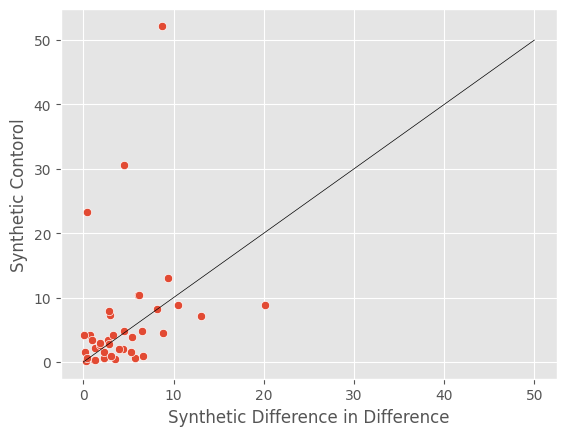

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
_x = np.linspace(0, 50, 30)
_y = _x
sns.scatterplot(data=result_mse, x="sdid", y="sc", ax = ax)
ax.plot(_x, _y, color='black',  linestyle='solid',linewidth = 0.5)
ax.set_xlabel("Synthetic Difference in Difference")
ax.set_ylabel("Synthetic Contorol")
#ax.set_xlim(0, 25)
#ax.set_ylim(0, 55)
plt.show()

In [29]:
result_mse.mean()

did     9.436689
sc      6.396863
sdid    4.448636
dtype: float64

In [30]:
 print("Done")

Done
